<a href="https://colab.research.google.com/github/Rajayogi/Indian-Food-Classification/blob/master/Indian_Food_Classifier_5_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install split-folders

In [0]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [0]:
# Check TF version and whether GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

1.13.1
/device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls "/content/gdrive/My Drive/Indian Food Classification"
!unzip -q "/content/gdrive/My Drive/Indian Food Classification/food-5.zip"

food-5.zip


In [0]:
# Check the extracted dataset folder
os.listdir('food-5/')

['Omelette', 'Biryani', 'Idly', 'Chicken_curry', 'Samosa']

In [0]:
Total_images_count = sum([len(files) for i, j, files in os.walk("food-5")])
print("Total number of images in the dataset")
print(Total_images_count)

Total number of images in the dataset
2500


In [0]:
Total_images_count_in_each_class = sum([len(files) for i, j, files in os.walk("food-5/Idly")])
print("Total number of images in each class")
print(Total_images_count_in_each_class)

Total number of images in each class
500


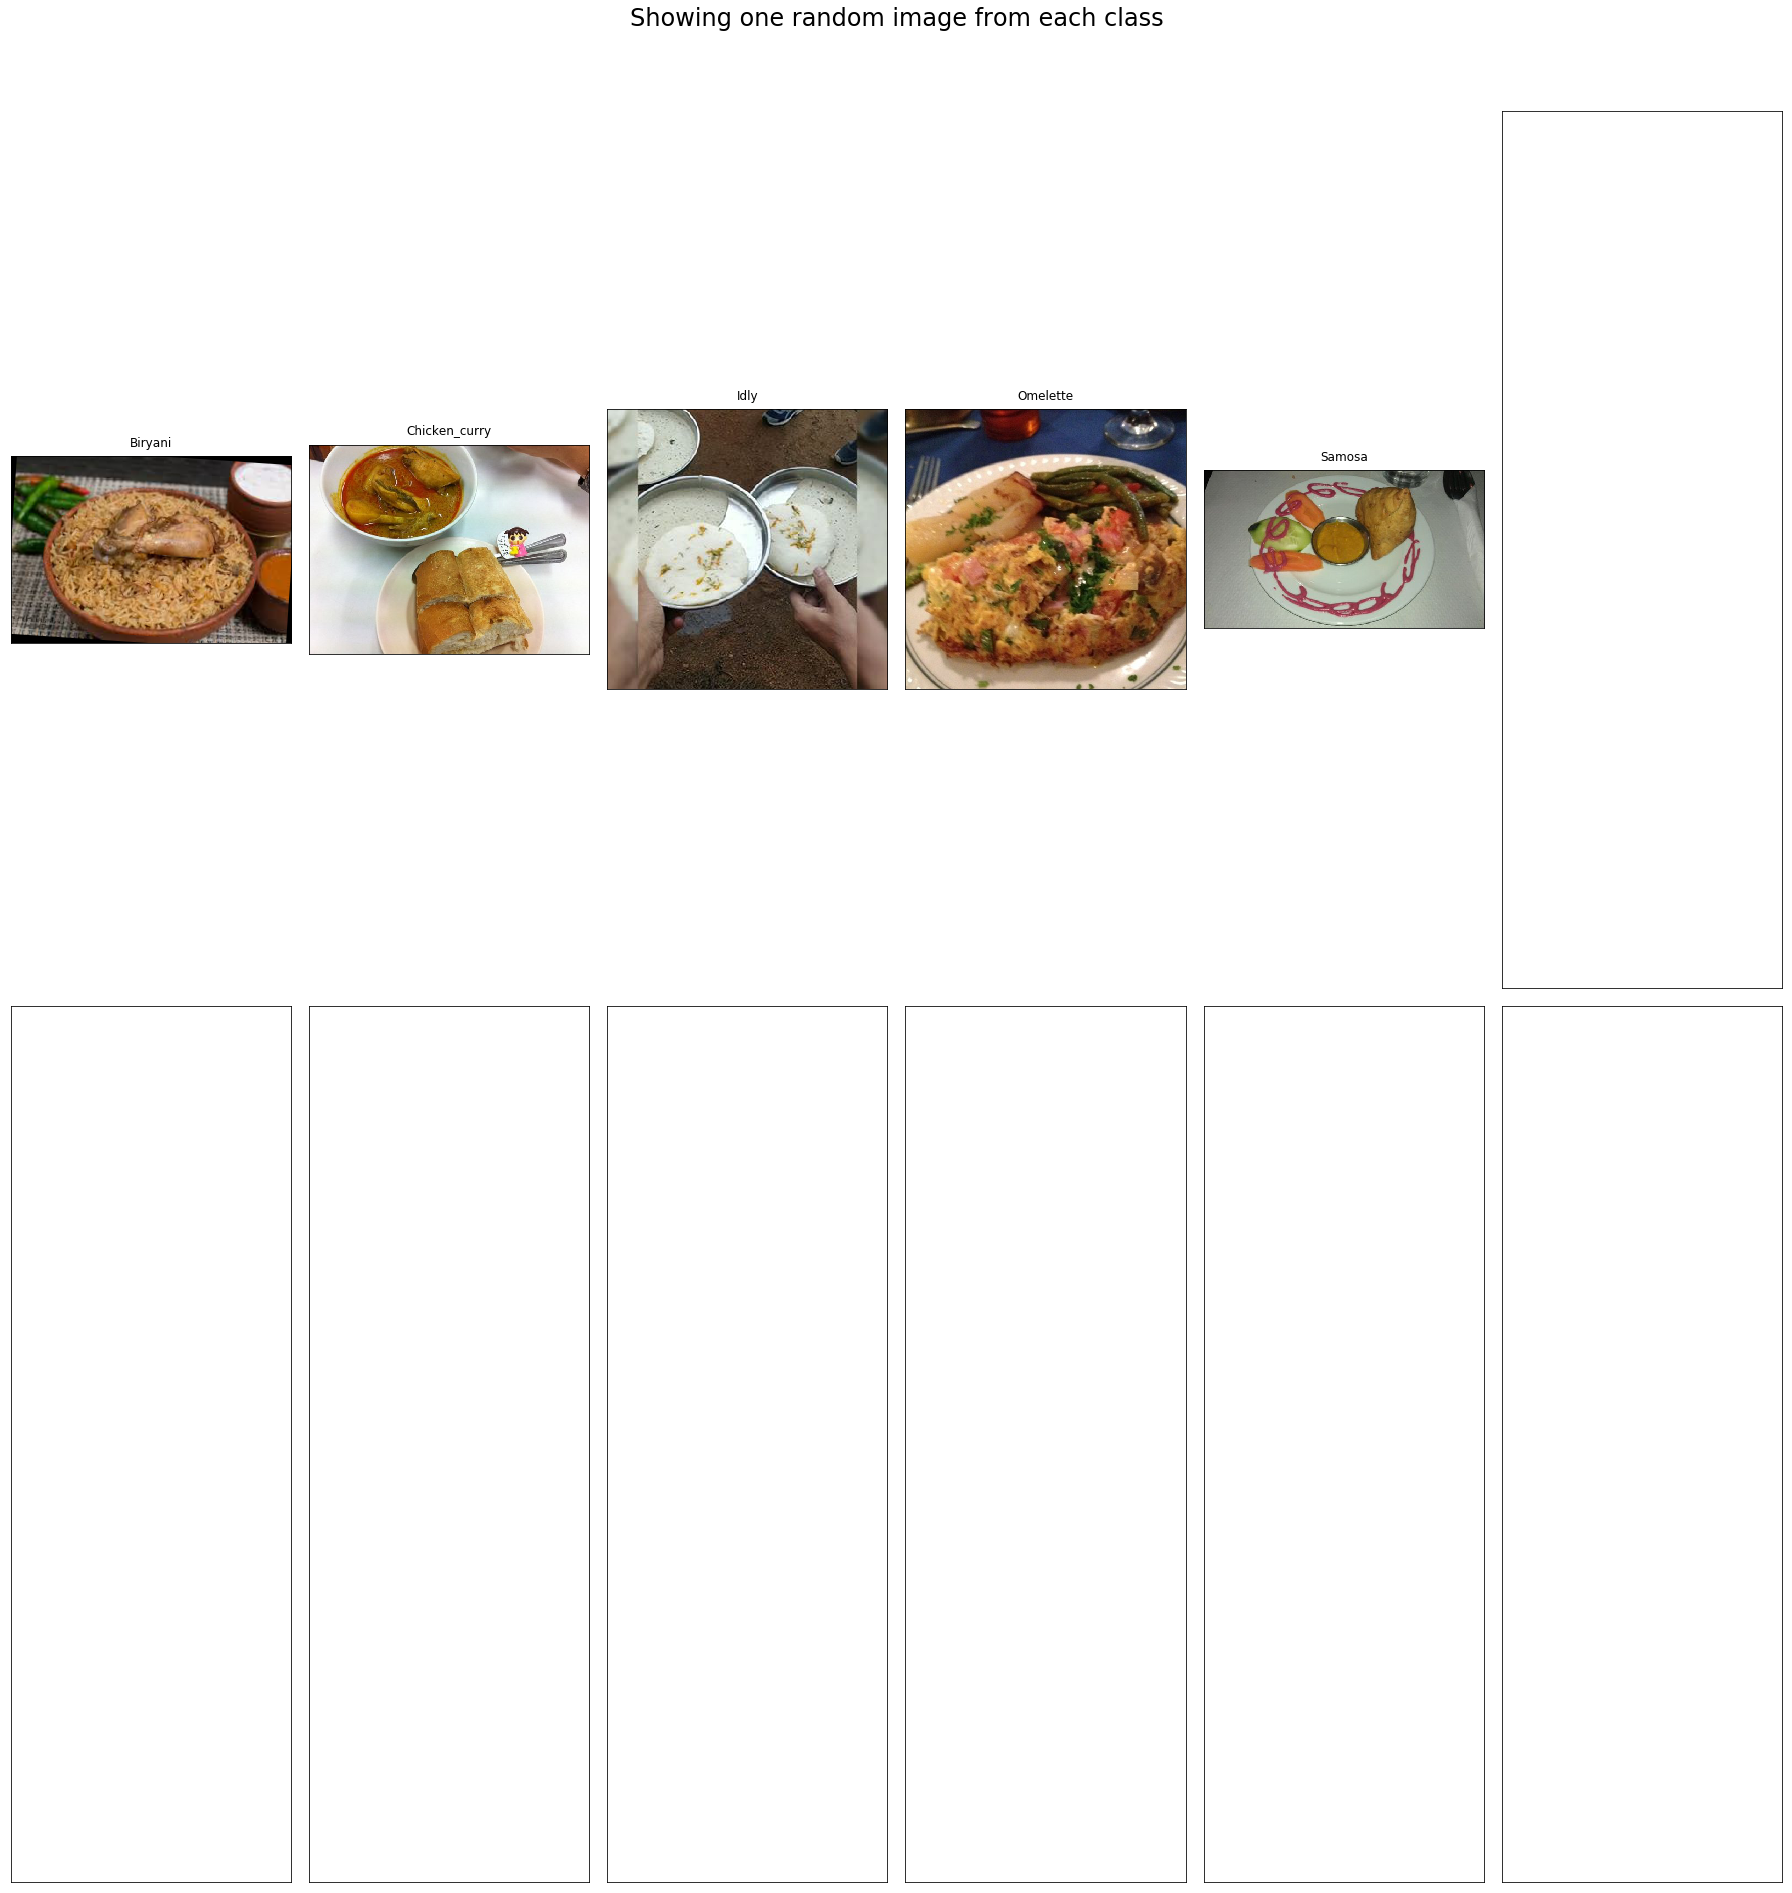

In [0]:
# Visualize the data, showing one image per class from 101 classes
rows = 2
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) 
data_dir = "food-5/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html

In [0]:
import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
split_folders.ratio('food-5', output="output", seed=1337, ratio=(.8, .1, .1)) # default values

In [0]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [55]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('train.txt', 'food-5', 'food-5/train')

Creating train data...


IndexError: ignored

In [56]:
train_files = sum([len(files) for i, j, files in os.walk("train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
2000


In [57]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
250


In [58]:

# List of all 101 types of foods(sorted alphabetically)
foods_sorted

['Biryani', 'Chicken_curry', 'Idly', 'Omelette', 'Samosa']

In [0]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = 'train'
  validation_data_dir = 'test'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit_generator(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [60]:

# Train the model with data from 3 classes
n_classes = 5
epochs = 5
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_101 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_101)

Found 2000 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
16/16 [==============================] - 5s 296ms/step - loss: 1.2959 - acc: 0.6320

Epoch 00001: val_loss improved from inf to 1.29588, saving model to bestmodel_5class.hdf5
125/125 [==============================] - 114s 909ms/step - loss: 1.5352 - acc: 0.3760 - val_loss: 1.2959 - val_acc: 0.6320
Epoch 2/5
16/16 [==============================] - 2s 127ms/step - loss: 0.9704 - acc: 0.7600

Epoch 00002: val_loss improved from 1.29588 to 0.97036, saving model to bestmodel_5class.hdf5
125/125 [==============================] - 52s 419ms/step - loss: 1.1319 - acc: 0.6635 - val_loss: 0.9704 - val_acc: 0

In [61]:

print(history.history.keys())
print(history.history['loss'])
print(history.history['acc'])
print(history.history['val_loss'])
print(history.history['val_acc'])

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
[1.5351775856018066, 1.1319387168884278, 0.8729713110923767, 0.6942831797599792, 0.5834184944629669]
[0.376, 0.6635, 0.7565, 0.7995, 0.8385]
[1.2958818972110748, 0.9703562520444393, 0.7376384101808071, 0.5984564330428839, 0.49192704912275076]
[0.632, 0.76, 0.828, 0.844, 0.86]


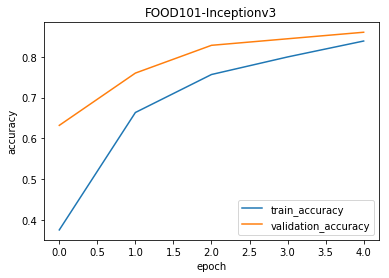

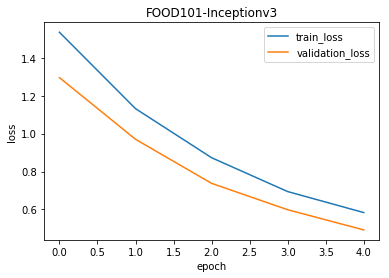

In [62]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_acc']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

In [64]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('bestmodel_5class.hdf5',compile = False)

CPU times: user 8.63 s, sys: 175 ms, total: 8.8 s
Wall time: 8.76 s


In [0]:
import os


#File Should not be loaded again and again so maintain a global variable

fileContent = None;

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

def getCaloriesForClass(name):
    global fileContent;
    if fileContent==None:
        fileContent = load_doc('caloriesfinal.csv')
        
    for line in fileContent.split('\n'):
        data = line.split(',');
        if data[0]==name:
            print("Calories for "+name+" is "+str(data[1])+"\n"+"Fat Content for "+name+" is "+str(data[2])+"\n"+"Carbohydrates Content for "+name+" is "+str(data[3])+"\n"+"cholestrol Content for "+name+" is "+str(data[4]))
    return "Needed Class Not Found"

In [0]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    foods_sorted.sort()
    #pred_value = food_list[index]
    print(foods_sorted[index])
    if show:
        #getCaloriesForClass(foods_sorted[index])
        plt.imshow(img[0])                           
        plt.axis('off')
        #plt.title(pred_value)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Biryani


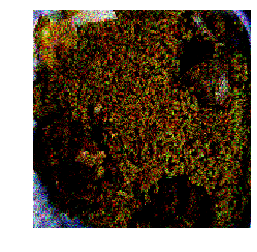

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Chicken_curry


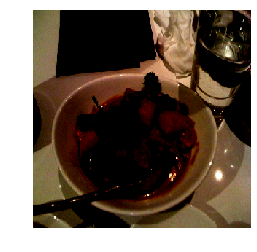

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Idly


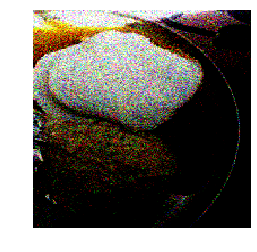

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Biryani


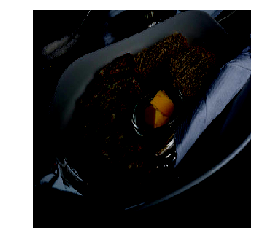

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Samosa


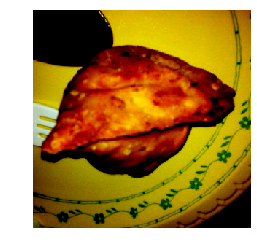

In [67]:
images = []
images.append('val/Biryani/augmented_image_104.png')
images.append('val/Chicken_curry/11207.jpg')
images.append('val/Idly/augmented_image_104.png')
images.append('val/Omelette/1048878.jpg')
images.append('val/Samosa/1016500.jpg')
predict_class(model_best, images, True)